# Poultry Diseases Detection


In [1]:
#!pip install --upgrade kornia > /dev/null
#!pip install --upgrade fastai > /dev/null

In [2]:
! pip install kaggle

In [3]:
from google.colab import files

# Upload kaggle.json file
uploaded = files.upload()

# Move kaggle.json into appropriate folder
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/


Saving kaggle.json to kaggle.json


In [6]:
!kaggle datasets download -d gauravduttakiit/poultry-diseases-detection

100% 7.89G/7.90G [04:18<00:00, 32.1MB/s]
100% 7.90G/7.90G [04:18<00:00, 32.8MB/s]


In [7]:
!unzip poultry-diseases-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/Coccidiosis/cocci.1492.jpg  
  inflating: train/Coccidiosis/cocci.1493.jpg  
  inflating: train/Coccidiosis/cocci.1495.jpg  
  inflating: train/Coccidiosis/cocci.1496.jpg  
  inflating: train/Coccidiosis/cocci.1497.jpg  
  inflating: train/Coccidiosis/cocci.150.jpg  
  inflating: train/Coccidiosis/cocci.1500.jpg  
  inflating: train/Coccidiosis/cocci.1502.jpg  
  inflating: train/Coccidiosis/cocci.1503.jpg  
  inflating: train/Coccidiosis/cocci.1504.jpg  
  inflating: train/Coccidiosis/cocci.1506.jpg  
  inflating: train/Coccidiosis/cocci.1507.jpg  
  inflating: train/Coccidiosis/cocci.1508.jpg  
  inflating: train/Coccidiosis/cocci.1509.jpg  
  inflating: train/Coccidiosis/cocci.1510.jpg  
  inflating: train/Coccidiosis/cocci.1511.jpg  
  inflating: train/Coccidiosis/cocci.1514.jpg  
  inflating: train/Coccidiosis/cocci.1515.jpg  
  inflating: train/Coccidiosis/cocci.1517.jpg  
  inflating: train/Coccidiosis/cocci.1

In [3]:
import shutil

# Replace 'folder_name' with the name of the folder you want to delete
folder_name = 'train/Salmonella'

# Use shutil.rmtree to delete the folder and its contents
shutil.rmtree(folder_name)


### Import all the Dependencies

In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from google.colab import drive

### Set all the Constants

In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

### Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE
)

Found 1946 files belonging to 2 classes.


**Watch below video on tensorflow input pipeline first if you don't know about tensorflow datasets**

In [7]:
class_names = dataset.class_names
class_names

['Healthy__poultry', 'New_castle']

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1]


### Visualize some of the images from our dataset

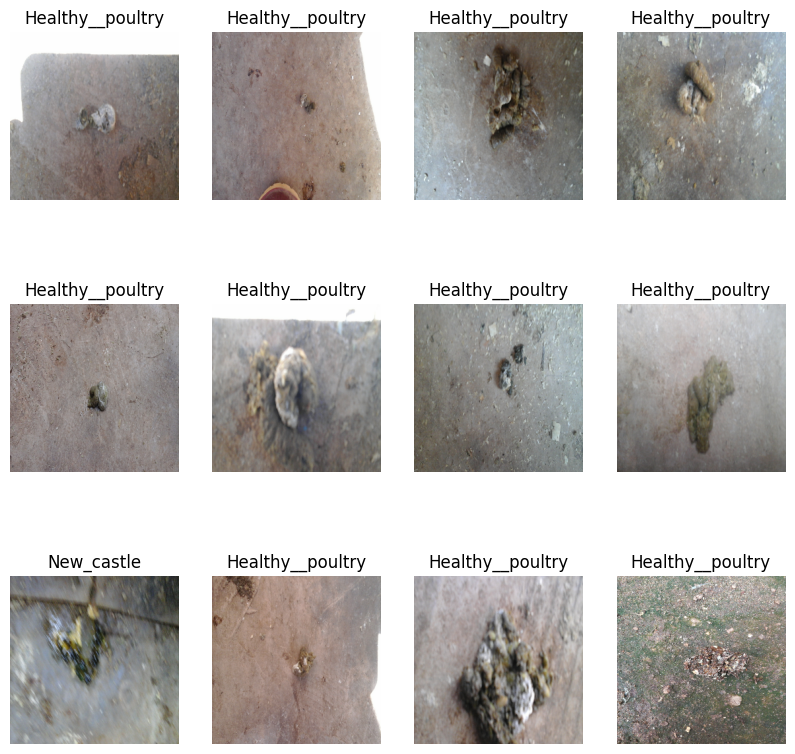

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 2 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [10]:
len(dataset)

61

In [11]:
train_size = 0.8
len(dataset)*train_size

48.800000000000004

In [12]:
train_ds = dataset.take(54)
len(train_ds)

54

In [13]:
test_ds = dataset.skip(54)
len(test_ds)

7

In [14]:
val_size=0.1
len(dataset)*val_size

6.1000000000000005

In [15]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds = test_ds.skip(6)
len(test_ds)

1

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

48

In [20]:
len(val_ds)

6

In [21]:
len(test_ds)

7

### Cache, Shuffle, and Prefetch the Dataset

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

In [23]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [24]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [25]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=2,
    epochs=50,
)

Epoch 1/50
48/48 - 111s - loss: 0.4676 - accuracy: 0.8307 - val_loss: 0.3685 - val_accuracy: 0.8750 - 111s/epoch - 2s/step
Epoch 2/50
48/48 - 14s - loss: 0.3749 - accuracy: 0.8667 - val_loss: 0.3519 - val_accuracy: 0.8958 - 14s/epoch - 282ms/step
Epoch 3/50
48/48 - 14s - loss: 0.3718 - accuracy: 0.8843 - val_loss: 0.3288 - val_accuracy: 0.9115 - 14s/epoch - 290ms/step
Epoch 4/50
48/48 - 14s - loss: 0.3075 - accuracy: 0.9039 - val_loss: 0.2971 - val_accuracy: 0.9062 - 14s/epoch - 287ms/step
Epoch 5/50
48/48 - 14s - loss: 0.3071 - accuracy: 0.9052 - val_loss: 0.3123 - val_accuracy: 0.9062 - 14s/epoch - 283ms/step
Epoch 6/50
48/48 - 15s - loss: 0.3450 - accuracy: 0.8908 - val_loss: 0.3260 - val_accuracy: 0.9010 - 15s/epoch - 310ms/step
Epoch 7/50
48/48 - 13s - loss: 0.3030 - accuracy: 0.9072 - val_loss: 0.3124 - val_accuracy: 0.9219 - 13s/epoch - 279ms/step
Epoch 8/50
48/48 - 13s - loss: 0.2876 - accuracy: 0.9111 - val_loss: 0.3115 - val_accuracy: 0.8802 - 13s/epoch - 278ms/step
Epoch 9/5

In [30]:
scores = model.evaluate(test_ds)

7/7 [==============================] - 41s 28ms/step - loss: 0.3275 - accuracy: 0.9152


**You can see above that we get 91.00% accuracy for our test dataset. This is considered to be a pretty good accuracy**

> Indented block



In [31]:
scores

[0.32748356461524963, 0.9151785969734192]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [32]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [33]:
history.params

{'verbose': 2, 'epochs': 50, 'steps': 48}

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [35]:
type(history.history['loss'])

list

In [36]:
len(history.history['loss'])

50

In [37]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.4676056504249573,
 0.37493428587913513,
 0.3718426823616028,
 0.3074938952922821,
 0.30705589056015015]

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

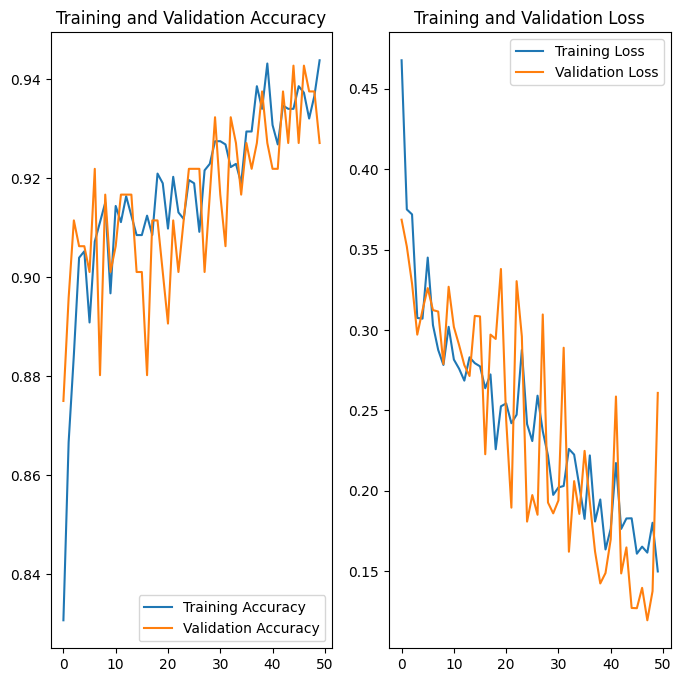

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: New_castle
1/1 [==============================] - 0s 31ms/step
predicted label: New_castle


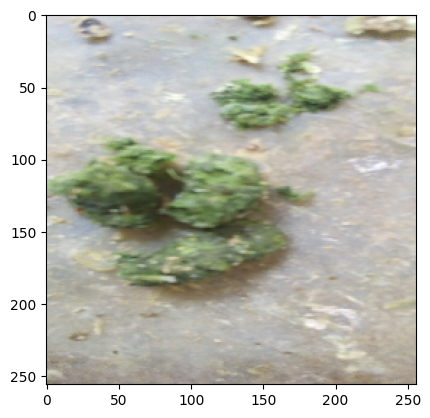

In [42]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [41]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 17ms/step


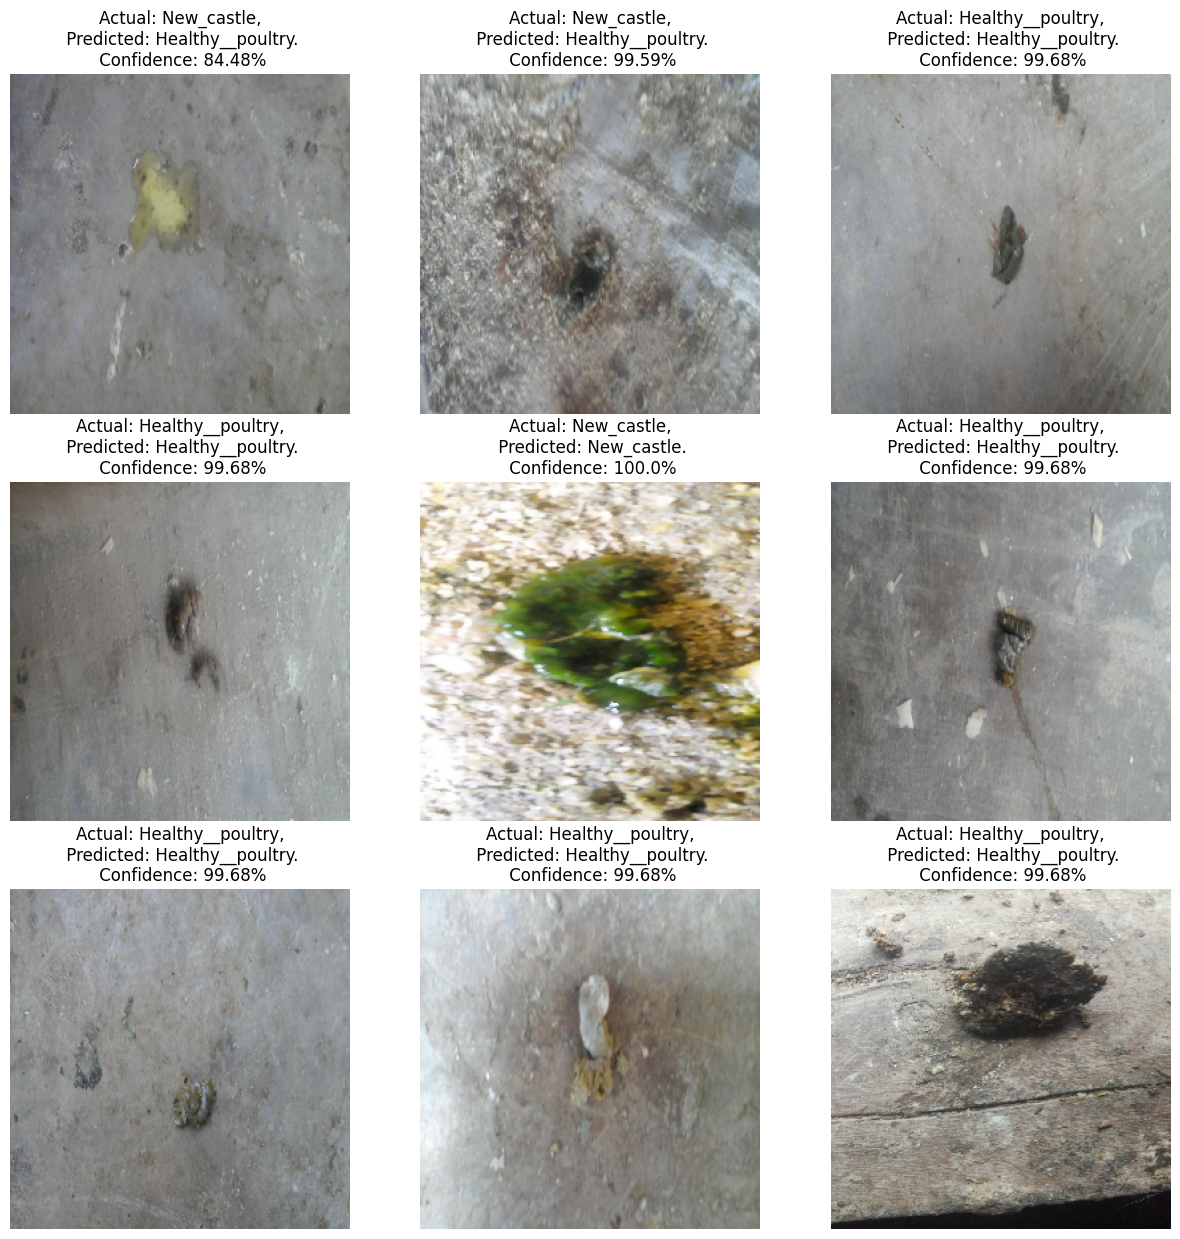

In [43]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [44]:
import os
model.save(f"./models/1")

In [45]:
import shutil
import os
from google.colab import files

# Folder to be zipped
folder_to_zip = 'models'

# Zip file name
zip_file_name = 'models.zip'

# Create a zip file of the folder
shutil.make_archive(zip_file_name.split('.')[0], 'zip', folder_to_zip)

# Download the zip file
files.download(zip_file_name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>